In [ ]:
# default_exp bayesian_hacker_unsupervised_clustering

# bayesian_hacker_unsupervised_clustering

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

figsize(12.5, 4)

In [ ]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

(0.0, 42.0)

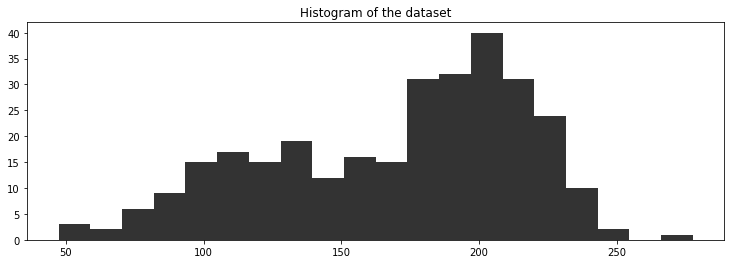

In [ ]:
plt.hist(data, bins=20, color="k", histtype='stepfilled', alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])

### Build model

In [ ]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p, shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))

print(f"prior assignment, with p = {p1.tag.test_value}")    
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.5
[0 1 0 1 1 1 0 0 1 0]


**set μ0 = 120, μ1 = 190 and σ0 = σ1 = 10.**

In [ ]:
with model:
    # Define distribution of two means and two stds
    centers = pm.Normal("centers", mu=np.array([120, 190]),
                        sd=np.array([10, 10]), shape=2)
    sds = pm.Uniform("sds", 0, 100, shape=2)
    # Attach with prob assignment
    center_i = pm.Deterministic("center_i", centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # Conbine with observations
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned std: ", sd_i.tag.test_value[:4], "...")

Random assignments:  [0 1 0 1] ...
Assigned center:  [120. 190. 120. 190.] ...
Assigned std:  [50. 50. 50. 50.] ...


In [ ]:
# MCMC
with model:
    step1 = pm.Metropolis(vars=[p, centers, sds])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sds]
>>Metropolis: [centers]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 133 seconds.
The number of effective samples is smaller than 10% for some parameters.


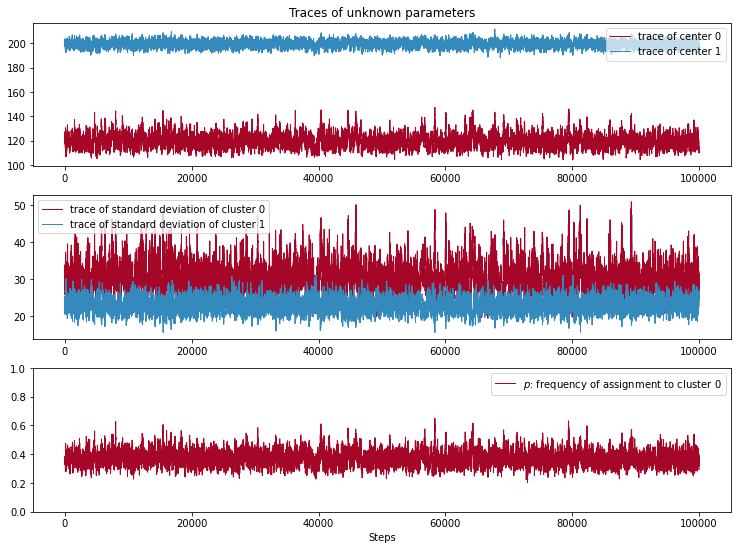

In [ ]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

We will sample the MCMC fifty thousand more times and visualize the progress below:

In [ ]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sds]
>>Metropolis: [centers]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


In [ ]:
figsize(12.5, 4)
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

### Cluster Investigation

In [ ]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

In [ ]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");